In [2]:
%pip install -Uqq fastai duckduckgo-search

Note: you may need to restart the kernel to use updated packages.


### Данные

1. Нам нужны данные в большом виде, в данном примере у нас есть лимит на 100 картинок в ddg поиске
2. Скачиваем данные по каждому классу классификации. **Кол-во данных должно приближаться к 100+**. В примере с Дотой, когда были все классы и 20 картинок на класс, **error_rate=0.7**

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url

charracters_array = [
    'lion',
    'pudge',
    'axe',
    'lina',
    'tinker',
    # 'slark',
    'invoker',
    'zeus',
    # 'drow',
    'sniper',
    'mirana',
    'windranger',
    # 'phantom assassin',
    # 'templar assassin',
    'viper',
    'luna',
    # 'dazzle',
    # 'phantom lancer',
    # 'juggernaut',
    'bloodseeker',
    'riki',
    'clinkz',
    'weaver',
    # 'spectre',
]

for character in charracters_array:
    try:
        images = ddg_images(character + " dota2 photo", max_results=100)
        for idx, image in enumerate(images): 
            try:
                download_url(image['image'], Path('images')/f"{character}_{idx}.jpg", show_progress=False)
            except Exception as e:    
                print(f"Error on {character}_{idx}.jpg")
                print(e)
    except Exception as e:
        print(f"Error on {character}")
        print(e)    

/usr/local/lib/python3.9/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.9/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.9/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


KeyboardInterrupt: 

### Чистим данные

Чистим данные: избавляемся от битых картинок

In [7]:
import os
from PIL import Image

def is_image_corrupted(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # verify that it is, in fact an image
        # делаем to_thumb для нашего сайза, была ошибка которая на следующем этапе ломалась если не сделать
        # `OSError(\nOSError: image file is truncated (23 bytes not processed)\n`
        Image.open(image_path).to_thumb(460, 460)
        return False
    except (IOError, SyntaxError) as e:
        return True

def clean_dataset(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if is_image_corrupted(file_path):
            print(f"Corrupted image detected and removed: {file_path}")
            os.remove(file_path)

clean_dataset('images')

Corrupted image detected and removed: images/lion_0.jpg
Corrupted image detected and removed: images/models


IsADirectoryError: [Errno 21] Is a directory: 'images/models'

### Подготовка к обучению

1. Нам нужна data (картинки) **X** asix
2. Нам нужны лейблы (классы: axe, pudge) **Y** asix

In [8]:
from fastai.vision.all import *
# y
def label_func(title): return title.split("_")[0]

# x
path = Path('images')
files = get_image_files(path)
len(files)

1371

Созадем **dataloaders**

Класс, в который мы прокидываем labels, data, transform function (нужна чтобы сделать все картинки одного размера 224) и batch_tfms, трансформ для батча. Нужен когда у нас более сложная задачка. Классификация нескольких классов например

`item_tfms=Resize(460), batch_tfms=aug_transforms(size=224)`



#### Используем seed

Seed — в контексте программирования, это число которое станет первым значением от которого пойдет генерерация. Таким образом, если оставлять seed одним и тем же = Мы уберем рандомность в делении данных, при обучении модели.

Тем самым уменьшим рандомность при обучении модели: 
 - Без seed: В первый раз модель взяла "хорошие" данные для валидации, и у нас получился маленький error rate. В другой раз при обучении модель взяла прохие, обучилась хуже. Мы думаем, что это из-за того что что-то сломалось, а на самом деле просто дело в данных 
 - C seed: У нас всегда остается одни и теже данные между обучениями => можем отбросить этот фактор и подступать к обучению более честно

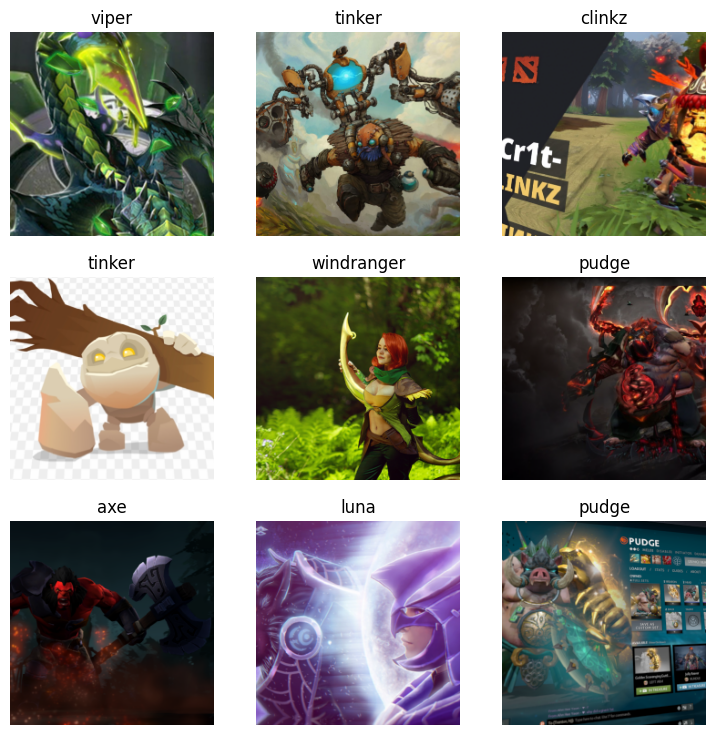

In [9]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, seed=42, item_tfms=Resize((460)), 
                                      batch_tfms=aug_transforms(size=(224)), method=ResizeMethod.Crop)

dls.show_batch()

### Обучение

Создаем learner
1.  Прокидываем dls(dataloaders)
2.  Выбираем модель resnet18/resnet34/resnet50/resnet/101 
3.  Прокидываем metrics=error_rate или accuracy

Про выбор моделей

https://huggingface.co/models?pipeline_tag=image-classification&sort=trending

>Models using architectures with more layers take longer to train, and are more prone to overfitting (i.e. you can't train them for as many epochs before the accuracy on the validation set starts getting worse). On the other hand, when using more data, they can be quite a bit more accurate.

This is the key to deep learning—determining how to fit the parameters of a model to get it to solve your problem. In order to fit a model, we have to provide at least one piece of information: how many times to look at each image (known as number of epochs). The number of epochs you select will largely depend on how much time you have available, and how long you find it takes in practice to fit your model. If you select a number that is too small, you can always train for more epochs later.


### Конспект

Всегда лучше использовать pre-trained models, потому что они быстрее в обучении под задачу из реального мира.
В академических кругах использование pre-trained моделей считается плохим тоном.

For instance, parts of pretrained models will handle edge, gradient, and color detection, which are needed for many tasks.

>jargon: Transfer learning: Using a pretrained model for a task different to what it was originally trained for.

`learn.fine_tune(1)`

This is the key to deep learning—determining how to fit the parameters of a model to get it to solve your problem. In order to fit a model, we have to provide at least one piece of information: how many times to look at each image (known as number of epochs). The number of epochs you select will largely depend on how much time you have available, and how long you find it takes in practice to fit your model. If you select a number that is too small, you can always train for more epochs later.

But why is the method called fine_tune, and not fit? fastai actually does have a method called fit, which does indeed fit a model (i.e. look at images in the training set multiple times, each time updating the parameters to make the predictions closer and closer to the target labels). But in this case, we've started with a pretrained model, and we don't want to throw away all those capabilities that it already has. As you'll learn in this book, there are some important tricks to adapt a pretrained model for a new dataset—a process called fine-tuning.

>jargon: Fine-tuning: A transfer learning technique where the parameters of a pretrained model are updated by training for additional epochs using a different task to that used for pretraining.



| Term | Meaning
|Label | The data that we're trying to predict, such as "dog" or "cat"
|Architecture | The _template_ of the model that we're trying to fit; the actual mathematical function that we're passing the input data and parameters to
|Model | The combination of the architecture with a particular set of parameters
|Parameters | The values in the model that change what task it can do, and are updated through model training
|Fit | Update the parameters of the model such that the predictions of the model using the input data match the target labels
|Train | A synonym for _fit_
|Pretrained model | A model that has already been trained, generally using a large dataset, and will be fine-tuned
|Fine-tune | Update a pretrained model for a different task
|Epoch | One complete pass through the input data
|Loss | A measure of how good the model is, chosen to drive training via SGD
|Metric | A measurement of how good the model is, using the validation set, chosen for human consumption
|Validation set | A set of data held out from training, used only for measuring how good the model is
|Training set | The data used for fitting the model; does not include any data from the validation set
|Overfitting | Training a model in such a way that it _remembers_ specific features of the input data, rather than generalizing well to data not seen during training
|CNN | Convolutional neural network; a type of neural network that works particularly well for computer vision tasks



/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should b

SuggestedLRs(valley=0.0008317637839354575)

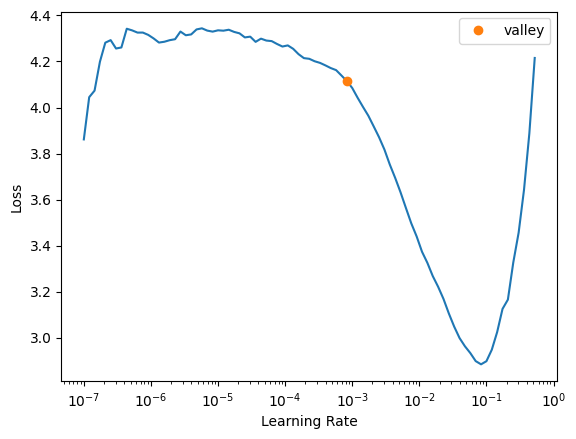

In [10]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

# используем для того чтобы найти оптимальный learning rate, который используем для второго параметра в fine_tune
learn.lr_find()

### Обучаем модель

`learn.fine_tune(3, 0.001737800776027143)`

Принимает 2 параметра — кол-во epoch (эпох/циклов). Сколько раз нужно обучать
Второй какую-то штуку, от которой будет зависеть скорость и точность обучения. ее надо вычсчитывать с помощью код блока вверху, и посдавлять сюда.

В итоге появится табличка, в которой будут отображены некоторые параметры

**error_rate** — самый важный параметр, от 0 до 1. Отвечает за результат нашей модели на валидационных данных
**train_loss** — значение loss на тренировочном сете, надо снижать
**valid_loss** — значение loss на валидирующем сете, надо снижать

*Если train_loss становится больше чем valid_loss — начинается оверфит.*

In [11]:
learn.fine_tune(4, 0.0020892962347716093)

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.796348,1.004083,0.328467,00:17
1,1.410897,0.743857,0.218978,00:17
2,1.071144,0.683555,0.215328,00:18
3,0.889463,0.678581,0.208029,00:17


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


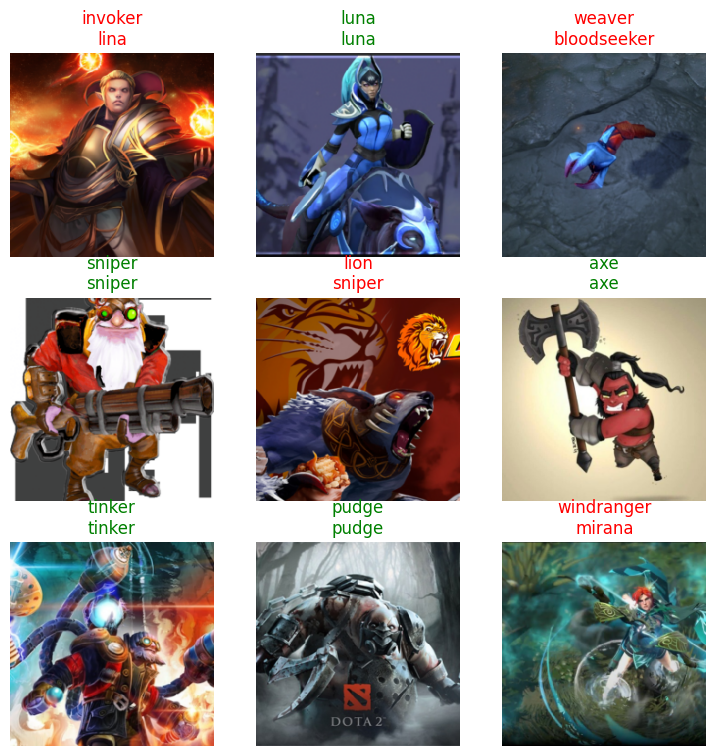

In [12]:
learn.show_results()

### Модель обучилась, теперь мы можем делать predictions

In [48]:
axe,_,probs  = learn.predict(PILImage.create('validate/axe.jpeg'))
pudge,_,probs  = learn.predict(PILImage.create('validate/pudge.jpeg'))
zeus,_,probs  = learn.predict(PILImage.create('validate/zeus.jpeg'))

print('Axe classification:', axe)
print('Pudge classification: ', pudge)
print('Zeus classification: ', zeus)

Axe:  axe
Pudge:  pudge
Zeus:  zeus


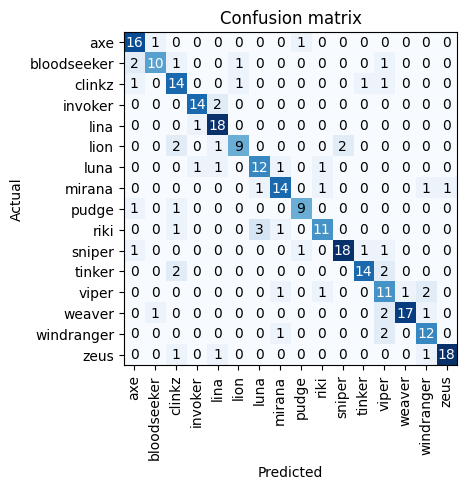

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Plot Top losses

*Loss — measurement of how good our model is. Loss will be "bad" if we predict wrongly and we confident about our prediction *

Plot Top losses — Говорит нам где loss самый высокий


Prediction/Actual/Loss/Probability

Модель предсказала что это {Predict} с увереностью в {Probability}, а на самом деле оказалось что это {Actual}

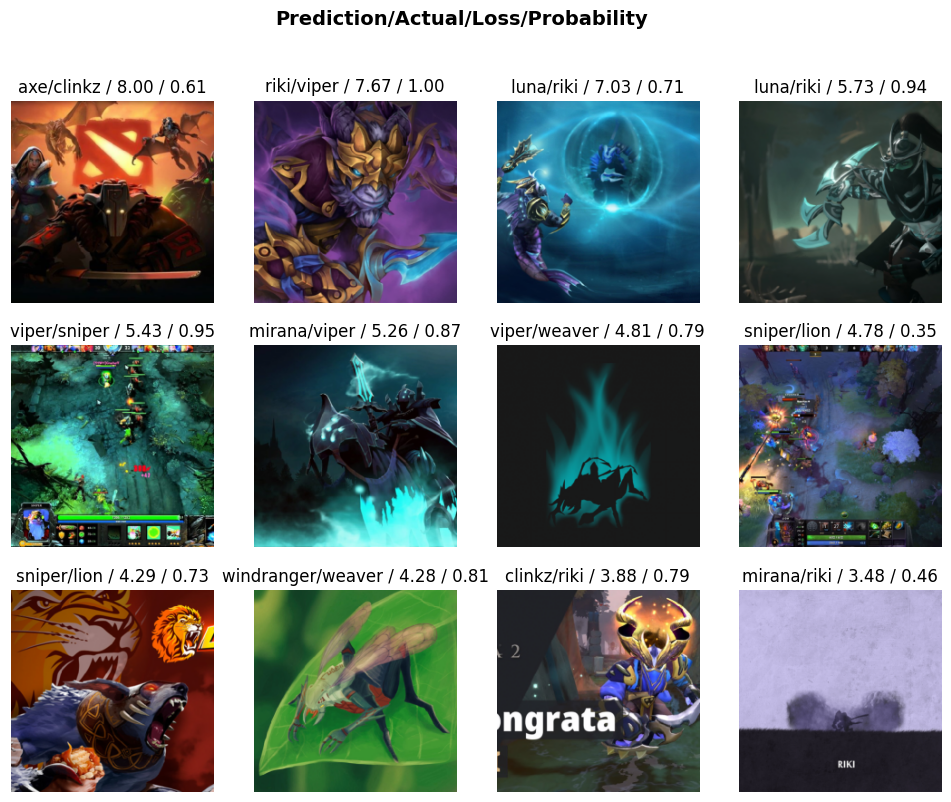

In [17]:
interp.plot_top_losses(12)

In [22]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
